###Librerías

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score

import xgboost as xgb
from hyperopt import hp, tpe, fmin

pd.set_option('display.max_columns', None)

### Lectura de la data

In [29]:
traindf = pd.read_csv('train.csv')
testdf = pd.read_csv('test.csv')
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Pre-procesamiento de la data

In [30]:
list_of_numerics=traindf.select_dtypes(include=['float','int']).columns
types= traindf.dtypes
missing= round((traindf.isnull().sum()/traindf.shape[0]),3)*100
overview= traindf.apply(lambda x: [round(x.min()), 
                                 round(x.max()), 
                                 round(x.mean()), 
                                 round(x.quantile(0.5))] if x.name in list_of_numerics else x.unique())

outliers= traindf.apply(lambda x: sum(
                                 (x<(x.quantile(0.25)-1.5*(x.quantile(0.75)-x.quantile(0.25))))|
                                 (x>(x.quantile(0.75)+1.5*(x.quantile(0.75)-x.quantile(0.25))))
                                 if x.name in list_of_numerics else ''))

explo = pd.DataFrame({'Types': types,
                      'Missing%': missing,
                      'Overview': overview,
                      'Outliers': outliers}).sort_values(by=['Missing%','Types'],ascending=False)
explo.transpose()

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage,GarageType,GarageFinish,GarageQual,GarageCond,GarageYrBlt,BsmtExposure,BsmtFinType2,BsmtQual,BsmtCond,BsmtFinType1,MasVnrType,MasVnrArea,Electrical,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,Heating,HeatingQC,CentralAir,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Types,object,object,object,object,object,float64,object,object,object,object,float64,object,object,object,object,object,object,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
Missing%,99.5,96.3,93.8,80.8,47.3,17.7,5.5,5.5,5.5,5.5,5.5,2.6,2.6,2.5,2.5,2.5,0.5,0.5,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Overview,"[nan, Ex, Fa, Gd]","[nan, Shed, Gar2, Othr, TenC]","[nan, Grvl, Pave]","[nan, MnPrv, GdWo, GdPrv, MnWw]","[nan, TA, Gd, Fa, Ex, Po]","[21, 313, 70, 69]","[Attchd, Detchd, BuiltIn, CarPort, nan, Basmen...","[RFn, Unf, Fin, nan]","[TA, Fa, Gd, nan, Ex, Po]","[TA, Fa, nan, Gd, Po, Ex]","[1900, 2010, 1979, 1980]","[No, Gd, Mn, Av, nan]","[Unf, BLQ, nan, ALQ, Rec, LwQ, GLQ]","[Gd, TA, Ex, nan, Fa]","[TA, Gd, nan, Fa, Po]","[GLQ, ALQ, Unf, Rec, BLQ, nan, LwQ]","[BrkFace, None, Stone, BrkCmn, nan]","[0, 1600, 104, 0]","[SBrkr, FuseF, FuseA, FuseP, Mix, nan]","[RL, RM, C (all), FV, RH]","[Pave, Grvl]","[Reg, IR1, IR2, IR3]","[Lvl, Bnk, Low, HLS]","[AllPub, NoSeWa]","[Inside, FR2, Corner, CulDSac, FR3]","[Gtl, Mod, Sev]","[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ...","[Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn, ...","[Norm, Artery, RRNn, Feedr, PosN, PosA, RRAn, ...","[1Fam, 2fmCon, Duplex, TwnhsE, Twnhs]","[2Story, 1Story, 1.5Fin, 1.5Unf, SFoyer, SLvl,...","[Gable, Hip, Gambrel, Mansard, Flat, Shed]","[CompShg, WdShngl, Metal, WdShake, Membran, Ta...","[VinylSd, MetalSd, Wd Sdng, HdBoard, BrkFace, ...","[VinylSd, MetalSd, Wd Shng, HdBoard, Plywood, ...","[Gd, TA, Ex, Fa]","[TA, Gd, Fa, Po, Ex]","[PConc, CBlock, BrkTil, Wood, Slab, Stone]","[GasA, GasW, Grav, Wall, OthW, Floor]","[Ex, Gd, TA, Fa, Po]","[Y, N]","[Gd, TA, Ex, Fa]","[Typ, Min1, Maj1, Min2, Mod, Maj2, Sev]","[Y, N, P]","[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, ...","[Normal, Abnorml, Partial, AdjLand, Alloca, Fa...","[1, 1460, 730, 730]","[20, 190, 57, 50]","[1300, 215245, 10517, 9478]","[1, 10, 6, 6]","[1, 9, 6, 5]","[1872, 2010, 1971, 1973]","[1950, 2010, 1985, 1994]","[0, 5644, 444, 384]","[0, 1474, 47, 0]","[0, 2336, 567, 478]","[0, 6110, 1057, 992]","[334, 4692, 1163, 1087]","[0, 2065, 347, 0]","[0, 572, 6, 0]","[334, 5642, 1515, 1464]","[0, 3, 0, 0]","[0, 2, 0, 0]","[0, 3, 2, 2]","[0, 2, 0, 0]","[0, 8, 3, 3]","[0, 3, 1, 1]","[2, 14, 7, 6]","[0, 3, 1, 1]","[0, 4, 2, 2]","[0, 1418, 473, 480]","[0, 857, 94, 0]","[0, 547, 47, 25]","[0, 552, 22, 0]","[0, 508, 3, 0]","[0, 480, 15, 0]","[0, 738, 3, 0]","[0, 15500, 43, 0]","[1, 12, 6, 6]","[2006, 2010, 2008, 2008]","[34900, 755000, 180921, 163000]"
Outliers,0,0,0,0,0,88,0,0,0,0,0,0,0,0,0,0,0,96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,103,69,2,125,7,0,7,167,29,61,20,2,26,31,1,82,0,0,35,68,30,5,5,21,32,77,2

In [31]:
categoricalColumns = ('Alley','Utilities','MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
            'BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
           'PoolQC','Fence','MiscFeature')

for col in categoricalColumns:
  traindf[col] = traindf[col].fillna('None')
  testdf[col] = testdf[col].fillna('None')

  

In [32]:
for col in ('Electrical','MSZoning','Exterior1st','Exterior2nd','KitchenQual','SaleType','Functional'):
    traindf[col]=traindf[col].fillna(traindf[col].mode()[0]) ## Llenar los vacíos con el valor que se repite más (mode()[0])
    testdf[col]=testdf[col].fillna(traindf[col].mode()[0])

In [33]:
for col in ('MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath',
            'GarageYrBlt','GarageCars','GarageArea'):
    traindf[col]=traindf[col].fillna(0) ## Llenar los vacíos con el valor 0)
    testdf[col]=testdf[col].fillna(0) 

In [34]:
traindf['LotFrontage'] = traindf['LotFrontage'].fillna(traindf['LotFrontage'].mean())
testdf['LotFrontage'] = testdf['LotFrontage'].fillna(testdf['LotFrontage'].mean())

### Visualización de la data

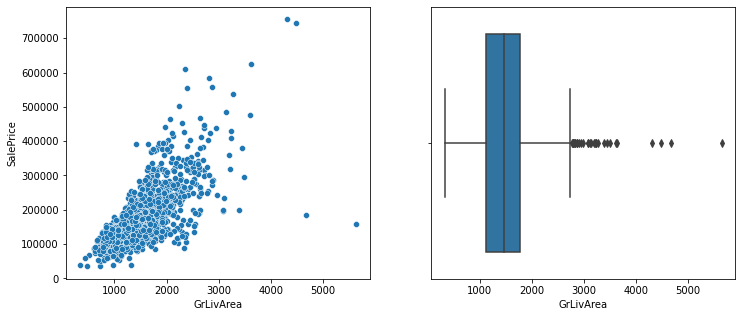

In [35]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
ax1 = sns.scatterplot(x='GrLivArea', y= 'SalePrice', data=traindf, ax=axes[0])
ax2 = sns.boxplot(x='GrLivArea', data=traindf, ax=axes[1]) 

In [36]:
traindf = traindf[traindf['GrLivArea']<4000]
traindf

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,None,None,None,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,None,MnPrv,None,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,T

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


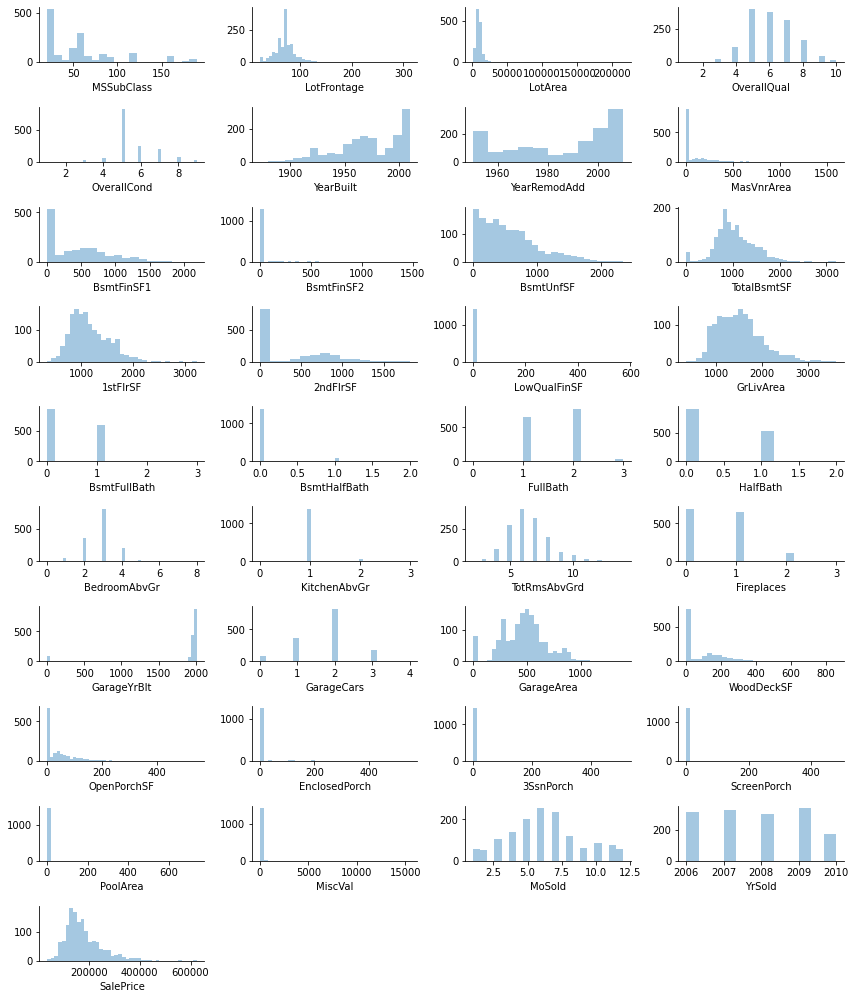

In [37]:
plt.figure(figsize=(12,14))
features=['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 
          'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',  'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath','BedroomAbvGr', 'KitchenAbvGr', 
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

n = 1
for f in features:
  plt.subplot(10,4,n)
  sns.distplot(traindf[f], kde=False)
  sns.despine()
  n += 1

plt.tight_layout()
plt.show()

### Feature Engineering

In [52]:
len_traindf = traindf.shape[0]
houses = pd.concat([traindf, testdf], sort=False)

for col in ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual",
            "FireplaceQu","GarageQual","GarageCond","PoolQC"]:
  houses[col] = houses[col].map({'Gd':4, 'TA':3, 'Ex':5, 'Fa': 2, 'Po': 1})

houses = pd.get_dummies(houses)

traindf = houses[:len_traindf] 
testdf = houses[len_traindf:]      

### Aplicando el modelo